`````{note}
This lecture is going to:
* Review what we mean by features in machine learning models
* Demonstrate polynomial fits for a noisy test function with known structure
* Formalize our idea of under/over fitting and show how model capacity influences train and validation errors
* Introduce regularization as an approach to reduce the train/validation gap and overfitting in models with many features
`````

`````{seealso}
* https://scikit-learn.org/stable/modules/feature_selection.html
`````

# Model Capacity, Overfitting, Regularization, and Ridge/LASSO

We're now at the point where we may have many features in a dataset, or where we want to generate many features to build predictive models. We need ways to generalize this process, and control how many features are used. 

As a reminder, we're currently interested in solving supervised regression problems of the form:
\begin{align*}
\hat{y}=f(\mathbf{X})
\end{align*}
where 
* $\hat{y}$ is a vector of outputs (one per data point)
* $\mathbf{X}$ is a 2D array of features (one row per data point, one column per feature)

We're only going to use linear regression models in today's lecture.

## Test function (Himmelblau's function)

Let's start with the special function we used for the optimization lecture
\begin{align}
f(x, y) = (x^2+y-11)^2+(x+y^2-7)^2
\end{align}
For clarity, I'm going to write this as 
\begin{align}
y=f(x_0, x_1) &= (x_0^2+x_2-11)^2+(x_0+x_1^2-7)^2\\
&=x_0^4+x_1^4+2x_0x_1^2+2x_1x_0^2-21x_0^2-13x_1^2-14x_0-22x_1+170
\end{align}
where y is the output/label, and $x_0,x_1$ are potential features (among many that we could choose)! This is a nice test function since it's analytical and is polynomial. If we try to find polynomial features of $x_0,x_1$, we should recover this form. 

```{seealso}
https://en.wikipedia.org/wiki/Himmelblau%27s_function
```

First, let's define the range of $x_1,x_2$ values we're interested in plotting over, and turn them into a 2D grid like we did in the optimization lecture.

In [1]:
import numpy as np

x1range = np.linspace(-5, 5)
x2range = np.linspace(-5, 5)

# Make 2d arrays for all the unique values of x_1/x_2
x1grid, x2grid = np.meshgrid(x1range, x2range)

Now, let's define a function to return Himmelblau's function, plus a little bit of random noise

In [2]:
import numpy as np


def himmelblau_with_noise(x1, x2, noise=0.1, seed=42):

    # Set the numpy random seed so the results are reproducible
    np.random.seed(seed)

    # Generate the himmelblau function
    himmelblau = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    # Multiple by a bit of Gaussian random noise and return
    noise = np.random.normal(loc=1, scale=noise, size=x1.shape)
    return himmelblau * noise

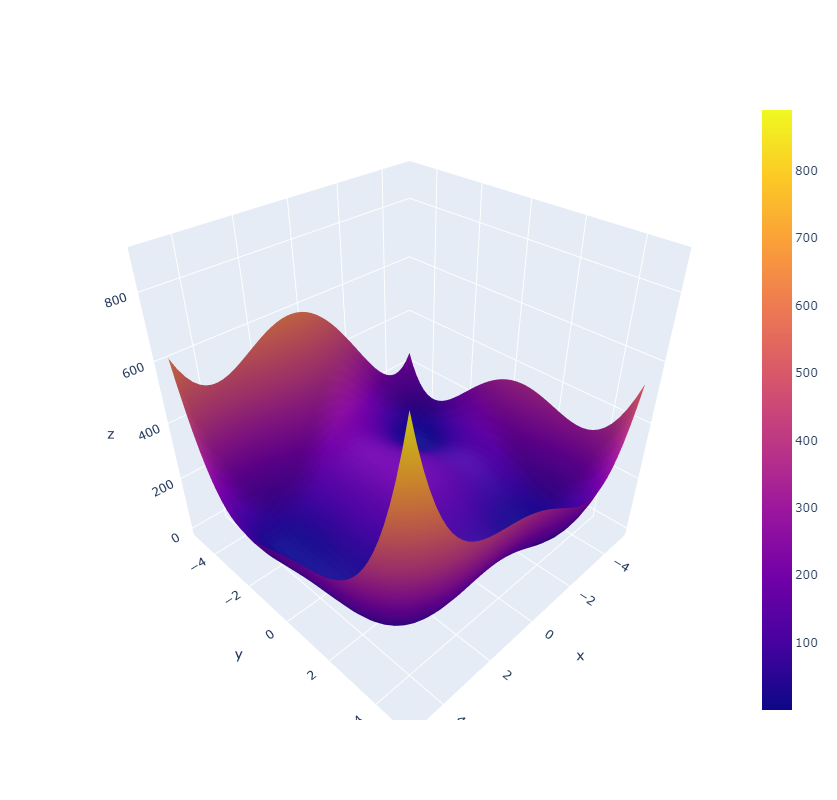

In [3]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(
            x=x1range, y=x2range, z=himmelblau_with_noise(x1grid, x2grid, noise=0)
        )
    ]
)

fig.update_layout(autosize=False, width=800, height=800)
fig.show()

Finally, let's plot the function without noise, and add points for 20 random points in that space. 

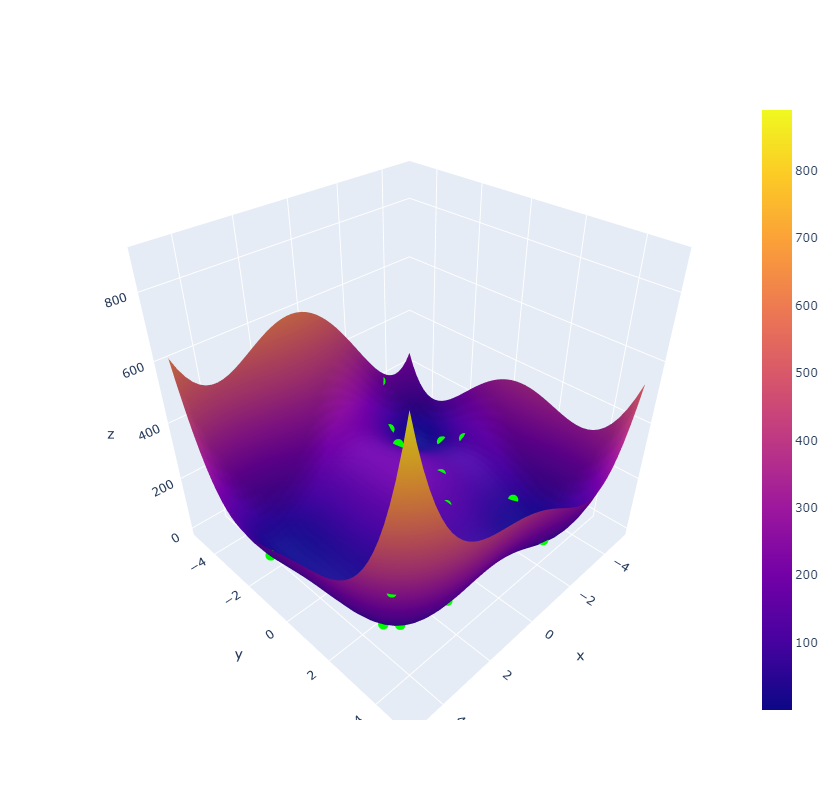

In [4]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(
            x=x1range, y=x2range, z=himmelblau_with_noise(x1grid, x2grid, noise=0)
        )
    ]
)

# Generate 20 samples from the noisy Himmelblau function
nsamples = 20
X = np.random.uniform(low=-5, high=5, size=(nsamples, 2))
y = himmelblau_with_noise(X[:, 0], X[:, 1], noise=0.1)

# Plot with plotly
fig.add_scatter3d(
    x=X[:, 0], y=X[:, 1], z=y, mode="markers", marker=dict(size=6, color="#00FF00")
)
fig.update_layout(autosize=False, width=800, height=800)
fig.show()

## Data generation: Generate 60 random samples and a random 60/20/20 train/val/test split

Before we do anything, we need to separate our data into train/val/test splits so that we don't overfit and we have some idea of how predictive our model is!

In [5]:
from sklearn.model_selection import train_test_split


# Helper function to generate train/val/test splits for
def generate_trainvaltest_data(nsamples):

    # Sample npoints random x1/x2 values
    np.random.seed(42)
    X = np.random.uniform(low=-5, high=5, size=(nsamples, 2))

    # Evaluate the function
    y = himmelblau_with_noise(X[:, 0], X[:, 1])

    # Generate the train/val/test splits
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, shuffle=True, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = generate_trainvaltest_data(60)

## Model fitting

### Base case (linear model with $x_0$, $x_1$ as the only the features)

Our goal will be to find the polynomial features that make this an easy function to fit. Before we do something interesting, let's start with the simplest thing we can try: a linear function using just $x_0$ and $x_1$ as features.

We'll use scikit-learn now that we've seen an example through the homework.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

mae = mean_absolute_error(y_val, model.predict(X_val))
rmse = mean_squared_error(y_val, model.predict(X_val)) ** 0.5

print(
    f"The MAE for the linear fit is {mae:0.2f}, compared to a standard deviation of {y_val.std():0.2f}"
)
print(
    f"The RMSE for the linear fit is {rmse:0.2f}, compared to a standard deviation of {y_val.std():0.2f}"
)

The MAE for the linear fit is 78.17, compared to a standard deviation of 87.41
The RMSE for the linear fit is 93.37, compared to a standard deviation of 87.41


In [7]:
def sklearn_predict_on_grid(model, x1grid, x2grid):
    # An sklearn pipeline or model will expect to predict on a NxM array,
    # where N is the number of data points and M is the number of features
    # This helper function will take two
    X = np.hstack((x1grid.reshape((-1, 1)), (x2grid.reshape((-1, 1)))))
    y = model.predict(X)

    return y.reshape(x1grid.shape)


# Test the function on the grid we were predicting on!
sklearn_predict_on_grid(model, x1grid, x2grid)

array([[115.60986945, 114.55446413, 113.49905881, ...,  66.00581939,
         64.95041406,  63.89500874],
       [117.03062096, 115.97521563, 114.91981031, ...,  67.42657089,
         66.37116557,  65.31576024],
       [118.45137246, 117.39596714, 116.34056181, ...,  68.84732239,
         67.79191707,  66.73651175],
       ...,
       [182.38518998, 181.32978466, 180.27437934, ..., 132.78113991,
        131.72573459, 130.67032927],
       [183.80594148, 182.75053616, 181.69513084, ..., 134.20189141,
        133.14648609, 132.09108077],
       [185.22669298, 184.17128766, 183.11588234, ..., 135.62264292,
        134.56723759, 133.51183227]])

Now, let's plot the linear fit, as well as the train and validation data.

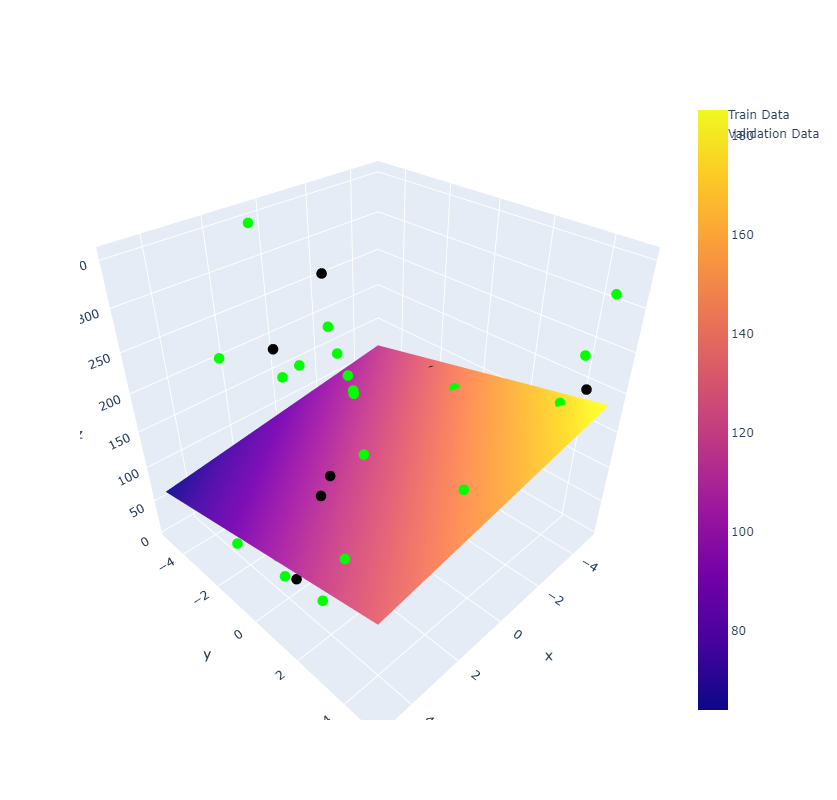

In [8]:
import plotly.graph_objects as go

# Plot the fitted model
fig = go.Figure(
    data=[
        go.Surface(
            x=x1range, y=x2range, z=sklearn_predict_on_grid(model, x1grid, x2grid)
        )
    ]
)

# Plot the train data
fig.add_scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode="markers",
    marker=dict(size=6, color="#00FF00"),
    name="Train Data",
)
# Plot the validation data
fig.add_scatter3d(
    x=X_val[:, 0],
    y=X_val[:, 1],
    z=y_val,
    mode="markers",
    marker=dict(size=6, color="#000000"),
    name="Validation Data",
)
fig.update_layout(autosize=False, width=800, height=800)
fig.show()

To evaluate the fit, we can also generate the parity plot!

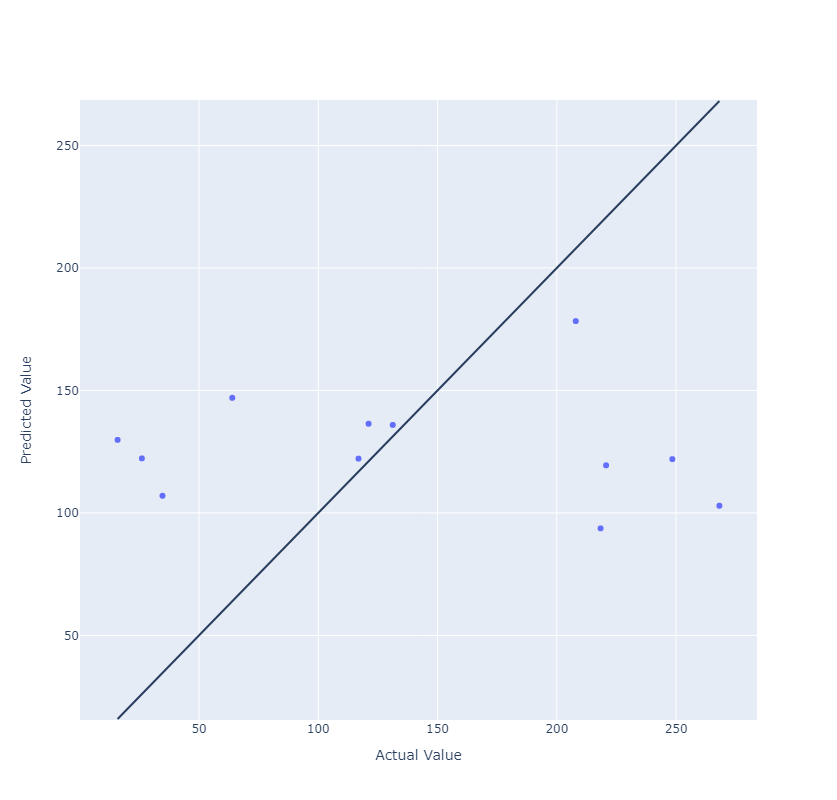

In [9]:
# Plot the fitted model
fig = go.Figure(data=[go.Scatter(x=y_val, y=model.predict(X_val), mode="markers")])

fig.add_shape(
    type="line",
    x0=y_val.min(),
    y0=y_val.min(),
    x1=y_val.max(),
    y1=y_val.max(),
)

fig.update_xaxes(
    title_text="Actual Value",
)
fig.update_yaxes(
    title_text="Predicted Value",
)

# Set the plot size
fig.update_layout(autosize=False, width=800, height=800)
fig.show()

### Polynomial case (linear model with polynomial features)

You saw in homework 2 that we can ask scikit-learn to generate polynomial features as part of a pipeline. Let's use that to generate all of the features up to the fourth power to fit. We know that fourth order is the right place to stop because we know the functional form, so otherwise this would be something we play around with. 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

model = LinearRegression()
model = make_pipeline(PolynomialFeatures(4), LinearRegression(fit_intercept=False))
model.fit(X_train, y_train)

mae = mean_absolute_error(y_val, model.predict(X_val))
rmse = mean_squared_error(y_val, model.predict(X_val)) ** 0.5

print(
    f"The MAE for the polynomial fit is {mae:0.2f}, compared to a standard deviation of {y_val.std():0.2f}"
)
print(
    f"The RMSE for the polynomial fit is {rmse:0.2f}, compared to a standard deviation of {y_val.std():0.2f}"
)

The MAE for the polynomial fit is 14.51, compared to a standard deviation of 87.41
The RMSE for the polynomial fit is 20.84, compared to a standard deviation of 87.41


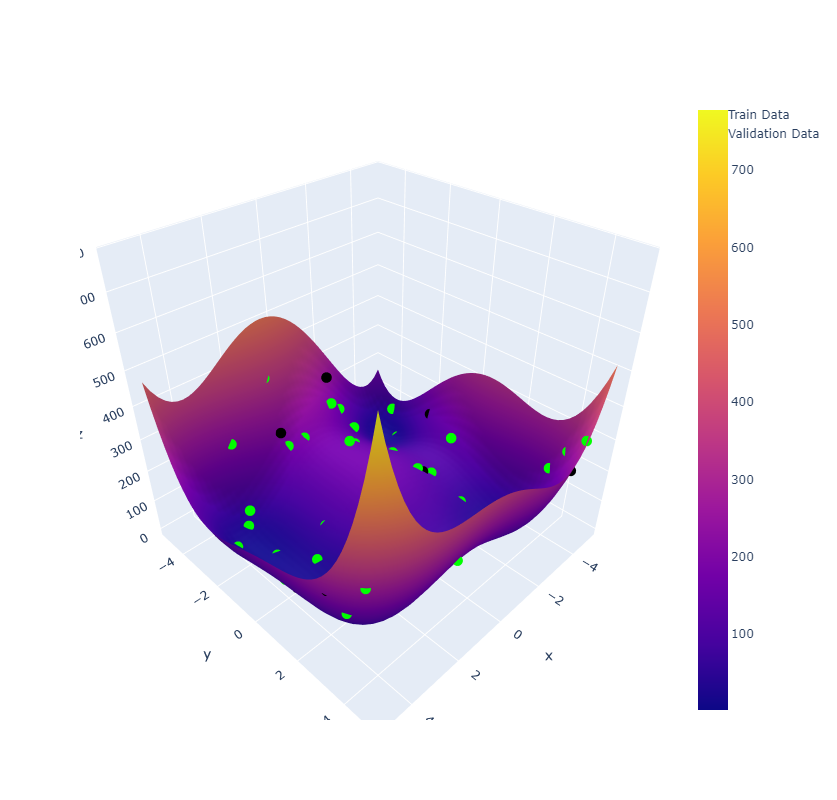

In [11]:
import plotly.graph_objects as go

# Plot the fitted model
fig = go.Figure(
    data=[
        go.Surface(
            x=x1range, y=x2range, z=sklearn_predict_on_grid(model, x1grid, x2grid)
        )
    ]
)
fig = go.Figure(
    data=[
        go.Surface(
            x=x1range, y=x2range, z=sklearn_predict_on_grid(model, x1grid, x2grid)
        )
    ]
)

# Plot the train data
fig.add_scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode="markers",
    marker=dict(size=6, color="#00FF00"),
    name="Train Data",
)
# Plot the validation data
fig.add_scatter3d(
    x=X_val[:, 0],
    y=X_val[:, 1],
    z=y_val,
    mode="markers",
    marker=dict(size=6, color="#000000"),
    name="Validation Data",
)
fig.update_layout(autosize=False, width=800, height=800)
fig.show()

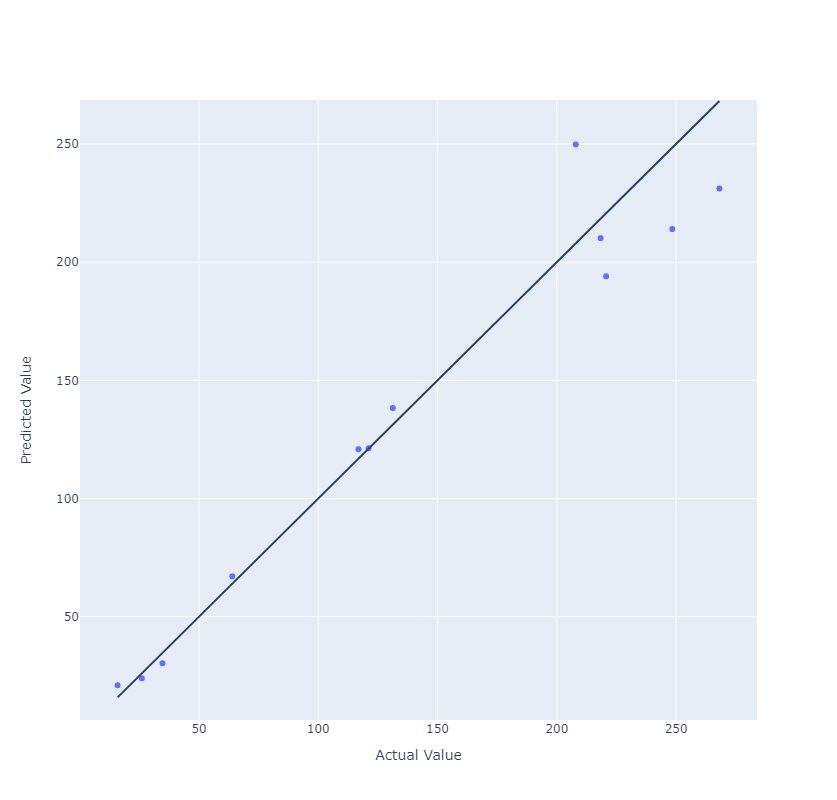

In [12]:
# Parity plot!
fig = go.Figure(data=[go.Scatter(x=y_val, y=model.predict(X_val), mode="markers")])

fig.add_shape(
    type="line",
    x0=y_val.min(),
    y0=y_val.min(),
    x1=y_val.max(),
    y1=y_val.max(),
)

fig.update_xaxes(
    title_text="Actual Value",
)
fig.update_yaxes(
    title_text="Predicted Value",
)

# Set the plot size
fig.update_layout(autosize=False, width=800, height=800)
fig.show()

Before we move on, let's do a quick check to see how the polynomial features compare with what we know to be true for the real model!

We can get descriptive names for the features with `model[0].get_feature_names_out()` and we can get the fitted coefficients with `model[1].coef_`.

````{tip}
If you're ever confused about what methods/functions/attributes that are available on an object, try `dir(object)`! I use this all the time because I can't remember all of the methods for every type of model. 

Try it with `dir(model[0])`!
````

In [13]:
for param, name in zip(model[1].coef_, model[0].get_feature_names_out()):
    print(f"The coefficient for {name} is {param:0.2f}")

The coefficient for 1 is 153.95
The coefficient for x0 is -14.54
The coefficient for x1 is -22.80
The coefficient for x0^2 is -18.03
The coefficient for x0 x1 is -0.12
The coefficient for x1^2 is -9.80
The coefficient for x0^3 is 0.03
The coefficient for x0^2 x1 is 1.85
The coefficient for x0 x1^2 is 1.69
The coefficient for x1^3 is 0.40
The coefficient for x0^4 is 0.87
The coefficient for x0^3 x1 is 0.01
The coefficient for x0^2 x1^2 is -0.07
The coefficient for x0 x1^3 is -0.02
The coefficient for x1^4 is 0.83


Remember the real functional form was $f(x_0, x_1) = x_0^4+x_1^4+2x_0x_1^2+2x_1x_0^2-21x_0^2-13x_1^2-14x_0-22x_1+170$. Most of the coefficients are pretty good! There are a few that are close to zero but not quite. 


## Model capacity and under/over-fitting data

Let's see how the number of polynomial features affects the fit for both the train and validation data. 

With 60 samples, this actually looks pretty good! Let's see how our model works with varying model complexity.

In [39]:
X_train, X_val, X_test, y_train, y_val, y_test = generate_trainvaltest_data(60)

train_rmse = {}
val_rmse = {}
for degree in range(10):

    # Make and fit a model with the appropriate degree!
    model = make_pipeline(
        PolynomialFeatures(degree), LinearRegression(fit_intercept=False)
    )
    model.fit(X_train, y_train)

    # Save the RMSE results in the dictionaries above
    train_rmse[degree] = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    val_rmse[degree] = mean_squared_error(y_val, model.predict(X_val)) ** 0.5

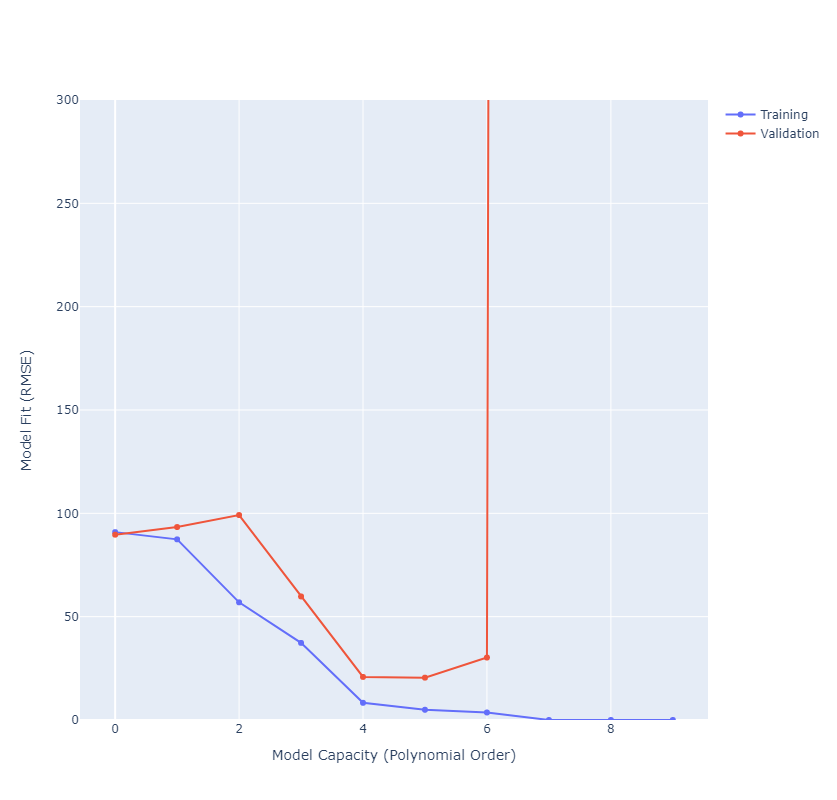

In [40]:
# Plot the generalization gap!
fig = go.Figure(
    data=[
        go.Scatter(
            x=list(train_rmse.keys()), y=list(train_rmse.values()), name="Training"
        )
    ]
)
fig.add_scatter(x=list(val_rmse.keys()), y=list(val_rmse.values()), name="Validation")

fig.update_xaxes(
    title_text="Model Capacity (Polynomial Order)",
)
fig.update_yaxes(
    range=[0, 300],
    title_text="Model Fit (RMSE)",
)

# Set the plot size
fig.update_layout(autosize=False, width=800, height=800)
fig.show()

There's a couple of interesting things here:
* The validation curve is usually above the training curve since the model hasn't seen that data before
* The training curve monotonically decreases with increasing capacity for these features and model
* The validation curve goes through a minimum at polynomial order 4, then stays roughly flat, then shoots up


````{note}
We call the gap between the training and validation results the **generalization gap**, since it shows how the models are able to generalize to the data in the validation set. Good features/models will have small generalization gaps, and by making smart modeling choices we can reduce it!
````

### Practice

Repeat the above with more than 60 data points. How do the results change?

## Reducing the generalization gap

To summarize the above:
* We can generate many features which may be useful in building a model
* Generating features that are actually used in the model can be very helpful
* If we generate too many features, we can actually make the model worse for predicting new data

We have a couple options:
* Tune the number or type of features being generated to minimize the validation error
* Change the model or features
* Change how we train the model (which we'll talk about here!)

### No regularization (linear regression)

As a reminder from the previous lecture on regression, we can think of linear regression as finding the parameters $\theta_i$ by minimizing the loss ($\mathcal{L}$) sum squared errors:
\begin{align*}
\min_{\theta}\mathcal{L} =\min_{\theta}  \left(y_i-\hat{y}_i\right)^2 
\end{align*}
To convince ourselves that this is true, let's do a quick demonstration using minimize to fit the loss function explicitly and plot the coefficients. 

In [42]:
from scipy.optimize import minimize


# Sum squared error loss function!
def loss(theta, X, y):
    y_pred = X @ theta
    loss = sum((y - y_pred) ** 2)
    return loss


# Linear regression fit using scipy.optimize.minimize
features = PolynomialFeatures(4).fit_transform(X_train)
sol = minimize(
    loss,
    np.ones(features.shape[1]),
    args=(features, y_train),
)
print(sol.x)

[ 1.53949599e+02 -1.45399893e+01 -2.28032359e+01 -1.80296670e+01
 -1.16131954e-01 -9.80455989e+00  3.38519193e-02  1.84701801e+00
  1.69166838e+00  4.00177274e-01  8.74503702e-01  5.93588927e-03
 -7.43961982e-02 -2.03560173e-02  8.34711093e-01]


In [45]:
X_example = np.array([[1, 2], [1, 3], [1, 4]])
np.hstack((X_example, (X_example[:, 0] * X_example[:, 1]).reshape((-1, 1))))

array([[1, 2, 2],
       [1, 3, 3],
       [1, 4, 4]])

In [32]:
PF = PolynomialFeatures(4).fit(X_train)
PF.transform(X_train).shape

(36, 15)

In [33]:
print(X_train.shape)

(36, 2)


As a reminder, for linear regression we can also calculate the coefficients directly using a linear algebra trick:
\begin{align*}
\theta=(X^TX)^{-1}X^Ty
\end{align*}
This is equivalent to minimizing the mean squared error like above! The actual numpy/sklearn implementation does something a bit more clever/faster than this, but it's mathematically the same.
`````{seealso}
* [Discussion of linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
* [Derivation of linear least squares](https://en.wikipedia.org/wiki/Linear_regression#Estimation_methods)
`````

In [46]:
# Directly calculate the parameters theta using linear least squares!
features = PolynomialFeatures(4).fit_transform(X_train)
theta = np.linalg.inv(features.T @ features) @ (features.T @ y_train)

# Should be the same as above!
print(theta)

[ 1.53949622e+02 -1.45399919e+01 -2.28032396e+01 -1.80296718e+01
 -1.16134191e-01 -9.80456426e+00  3.38521625e-02  1.84701800e+00
  1.69166837e+00  4.00177423e-01  8.74503939e-01  5.93591444e-03
 -7.43961610e-02 -2.03558873e-02  8.34711298e-01]


Now, let's do the same thing with scikit-learn. We should get the same results!

In [47]:
# Linear Regression fit using sklearn
model = LinearRegression()
model = make_pipeline(PolynomialFeatures(4), LinearRegression(fit_intercept=False))
model.fit(X_train, y_train)

# Print the coefficients from sklearn, showing you get the same answer using either method!
print(model[1].coef_)

[ 1.53949622e+02 -1.45399919e+01 -2.28032396e+01 -1.80296718e+01
 -1.16134191e-01 -9.80456426e+00  3.38521625e-02  1.84701800e+00
  1.69166837e+00  4.00177423e-01  8.74503939e-01  5.93591444e-03
 -7.43961610e-02 -2.03558873e-02  8.34711298e-01]


These coefficients are exactly the same as the custom model we optimized. As a final step and for comparison with the next steps, we'll repeat the plot from above to see how the train/validation errors scale with maximum polynomial degree.

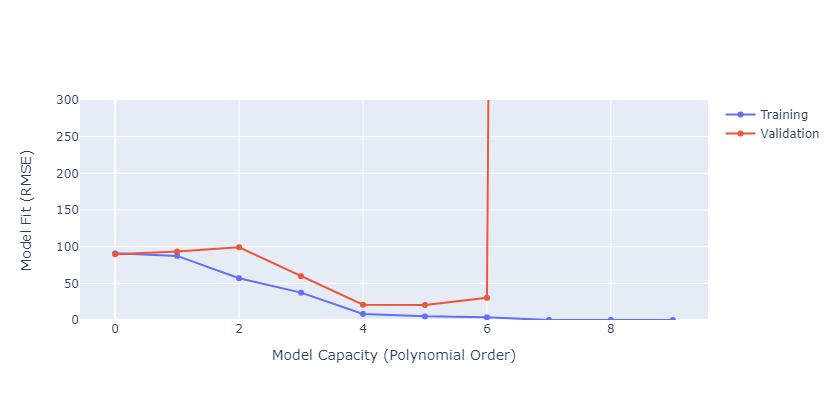

In [48]:
# Plot the generalization gap!
fig = go.Figure(
    data=[
        go.Scatter(
            x=list(train_rmse.keys()), y=list(train_rmse.values()), name="Training"
        )
    ]
)
fig.add_scatter(x=list(val_rmse.keys()), y=list(val_rmse.values()), name="Validation")

fig.update_xaxes(
    title_text="Model Capacity (Polynomial Order)",
)
fig.update_yaxes(
    range=[0, 300],
    title_text="Model Fit (RMSE)",
)

# Set the plot size
fig.update_layout(autosize=False, width=600, height=400)
fig.show()

### L2 regularization (ridge regression, or Tikhonov regularization)


Regularization refers to a small change in how we fit our models. We're not going to change the model at all - we're only going to train the fitting procedure. Specifically, we're going to add a term to our loss function that includes the absolute size of the fitted parameters. 

One of the most common types of regularization is L2 regularization. When this is applied to a linear model, it's called ridge regression. This approach is often effective at reducing the train/validation gap:
\begin{align*}
\min_{\theta}\mathcal{L} =\min_{\theta} \left[ \left(y_i-\hat{y}_i\right)^2 + \alpha \sum_j \theta_j^2\right]
\end{align*}
where $\theta_j$ are the model parameters, and $\alpha$ is a parameter that we can adjust to control the regularization.

`````{note}
* **Regularization:** Strategy to reduce the train/validation gap
* **L2 regularization:** Otherwise known as Tikhonov regularization, or Ridge regression if the model is linear
* $\alpha$: an empirical parameter that controls how strong the regularization is 
`````

`````{warning}
Large  $\alpha$ effectively reduce the model capacity. If you make the $\alpha$ too large it will hurt the training errors!
`````

To demonstrate this we'll again do the fit using a custom loss function, and using the `Ridge` model from sklearn.

In [51]:
from scipy.optimize import minimize


# Sum squared error loss function!
def loss(theta, X, y, alpha=1):
    y_pred = X @ theta
    loss = sum((y - y_pred) ** 2) + alpha * (theta**2).sum()
    return loss


# Linear regression fit using scipy.optimize.minimize, showing you get the same answer using either method!
sol = minimize(
    loss,
    np.ones(model[1].coef_.shape),
    args=(PolynomialFeatures(4).fit_transform(X_train), y_train, 1),
)
print(sol.x)

[ 1.10577143e+02 -1.47790742e+01 -2.24582511e+01 -1.12169568e+01
 -2.14566727e+00 -4.56354974e+00  1.28851404e-02  2.01520670e+00
  1.44096812e+00  4.85429704e-01  6.31906242e-01  1.39102666e-01
 -2.76513321e-01 -1.08583595e-02  6.92339536e-01]


In [53]:
from sklearn.linear_model import Ridge

# Linear Regression fit using sklearn
model = make_pipeline(PolynomialFeatures(4), Ridge(fit_intercept=False))
model.fit(X_train, y_train)

# Print the coefficients from sklearn, showing you get the same answer using either method!
print(model[1].coef_)

[ 1.10577190e+02 -1.47790704e+01 -2.24582518e+01 -1.12169653e+01
 -2.14566467e+00 -4.56355739e+00  1.28849648e-02  2.01520651e+00
  1.44096846e+00  4.85429568e-01  6.31906595e-01  1.39102452e-01
 -2.76513114e-01 -1.08582974e-02  6.92339815e-01]


Same coefficients either way! Let's see how this affects the model performance as the number of features increases.

In [66]:
from sklearn.linear_model import Ridge

X_train, X_val, X_test, y_train, y_val, y_test = generate_trainvaltest_data(60)

train_rmse = {}
val_rmse = {}
for degree in range(10):

    # Make and fit a model with the appropriate degree!
    model = LinearRegression()
    model = make_pipeline(
        PolynomialFeatures(degree), Ridge(fit_intercept=False, alpha=1000000)
    )
    model.fit(X_train, y_train)

    # Save the RMSE results in the dictionaries above
    train_rmse[degree] = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    val_rmse[degree] = mean_squared_error(y_val, model.predict(X_val)) ** 0.5

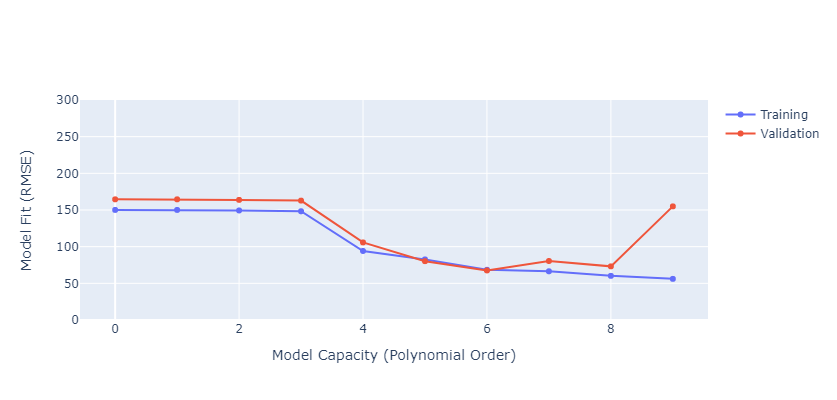

In [67]:
# Plot the generalization gap!
fig = go.Figure(
    data=[
        go.Scatter(
            x=list(train_rmse.keys()), y=list(train_rmse.values()), name="Training"
        )
    ]
)
fig.add_scatter(x=list(val_rmse.keys()), y=list(val_rmse.values()), name="Validation")

fig.update_xaxes(
    title_text="Model Capacity (Polynomial Order)",
)
fig.update_yaxes(
    range=[0, 300],
    title_text="Model Fit (RMSE)",
)

# Set the plot size
fig.update_layout(autosize=False, width=600, height=400)
fig.show()

### Practice: Vary the alpha parameter and describe the results

### L1 regularization (LASSO)

Another common regularization strategy is L1 regularization. When applied to linear models this is called LASSO regression.
\begin{align*}
\min_{\theta}\mathcal{L} =\min_{\theta} \left[ \frac{\left(y_i-\hat{y}_i\right)^2}{2N} + \alpha \sum_j |\theta_j|\right]
\end{align*}
where $\theta_j$ are the model parameters, and $\alpha$ is a parameter that we can adjust to control the regularization, and N is the number of training data. The LASSO model has the interesting property that, after minimization, many of the parameters tend to be 0. Non-zero elements will tell you which features are important. LASSO can be used as a feature selection strategy!

`````{note}
* **Feature selection:** A step in an ML process to identify which features are most important and only use those in the final model
* **LASSO:** L1 regularization applied to linear regression. LASSO tends to set some parameters equal to 0!
`````




In [68]:
from scipy.optimize import minimize


# Sum squared error loss function!
def loss(theta, X, y, alpha=1):
    y_pred = X @ theta

    # Loss from https://github.com/scikit-learn/scikit-learn/blob/36958fb24/sklearn/linear_model/_coordinate_descent.py#L1134
    loss = sum((y - y_pred) ** 2) / 2 / len(y) + alpha * np.abs(theta).sum()
    return loss


# Linear regression fit using scipy.optimize.minimize, showing you get the same answer using either method!
features = PolynomialFeatures(4).fit_transform(X_train)
sol = minimize(
    loss,
    np.zeros(features.shape[1]),
    args=(features, y_train, 1),
)
print(sol.x)

[ 1.37367827e+02 -1.36819188e+01 -2.10177436e+01 -1.52727106e+01
 -4.43691387e-01 -7.48392107e+00 -2.13238678e-02  1.87829041e+00
  1.58855161e+00  3.47634011e-01  7.64802596e-01  4.07003966e-02
 -1.38652933e-01 -3.05512108e-02  7.60142327e-01]


In [70]:
from sklearn.linear_model import Lasso

# Linear Regression fit using sklearn
model = Lasso()
model = make_pipeline(PolynomialFeatures(4), Lasso(fit_intercept=False,alpha=100))
model.fit(X_train, y_train)

# Print the coefficients from sklearn, showing you get the same answer using either method!
print(model[1].coef_)

[ 0.         -0.         -0.          0.          0.          0.
 -0.20301903  1.36768022  0.57638525 -0.6974903   0.29745751 -0.01954642
 -0.44879673  0.02585867  0.76245678]


In [73]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X_train, X_val, X_test, y_train, y_val, y_test = generate_trainvaltest_data(60)
train_rmse = {}
val_rmse = {}
for degree in range(14):

    # Make and fit a model with the appropriate degree!
    model = LinearRegression()
    model = make_pipeline(
        PolynomialFeatures(degree),
        Lasso(fit_intercept=False, alpha=0.1, max_iter=100000),
    )
    model.fit(X_train, y_train)

    # Save the RMSE results in the dictionaries above
    train_rmse[degree] = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    val_rmse[degree] = mean_squared_error(y_val, model.predict(X_val)) ** 0.5

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+02, tolerance: 8.110e+01

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.817e+02, tolerance: 8.110e+01

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.570e+02, tolerance: 8.110e+01

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

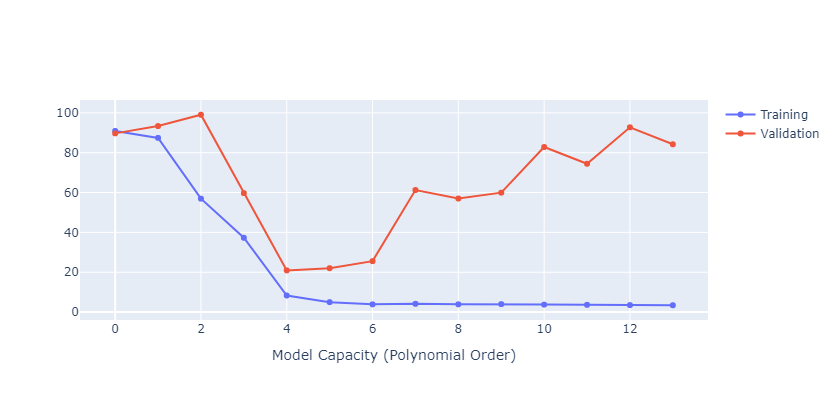

In [74]:
# Plot the generalization gap!
fig = go.Figure(
    data=[
        go.Scatter(
            x=list(train_rmse.keys()), y=list(train_rmse.values()), name="Training"
        )
    ]
)
fig.add_scatter(x=list(val_rmse.keys()), y=list(val_rmse.values()), name="Validation")

fig.update_xaxes(
    title_text="Model Capacity (Polynomial Order)",
)
# fig.update_yaxes(
#     range=[0, 300],
#     title_text="Model Fit (RMSE)",
# )

# Set the plot size
fig.update_layout(autosize=False, width=600, height=400)
fig.show()

Notice the validation error, especially with a very large model, is significantly better here. There's some variability depending on how the model is fit and the initial parameters used before the minimization. 

In [75]:
model[1].coef_

array([ 1.05504179e+02, -1.55713475e+01, -3.26827898e+01, -2.93150481e+00,
        0.00000000e+00,  1.56917988e+00,  6.24035692e-01,  3.39145160e+00,
        6.00851255e+00,  3.23556286e-02, -4.07602827e-01, -5.05190409e-01,
       -2.16822370e+00,  8.20101511e-01,  6.34748519e-03, -2.06401186e-01,
        1.52093993e-01, -2.45712021e-01, -3.10834268e-02, -2.53199496e-02,
        1.85133447e-01,  5.73018112e-02,  3.28512222e-02, -5.58646465e-03,
        1.41771318e-02,  1.09305026e-01,  2.71844507e-02, -1.87441338e-03,
        9.96139849e-03, -5.65230985e-03, -9.81227502e-03, -3.59263803e-03,
        1.28744385e-02, -1.52190311e-02, -6.77897427e-03, -6.97752721e-03,
       -5.43369098e-04, -3.54640804e-03,  2.19505894e-03,  2.70718758e-04,
        1.40100716e-03, -1.49973939e-03,  8.58498929e-04,  7.02159583e-04,
        9.89954595e-04,  3.53468223e-04,  3.99166115e-05, -1.10245828e-04,
       -3.05895923e-04,  5.17477686e-04, -2.29817609e-04,  1.69549720e-04,
        4.17475089e-05, -

As one final check, let's see how the results for parameter coefficients compare with the known Himmelblau function parameters from above!
\begin{align}
y=f(x_0, x_1) &= (x_0^2+x_2-11)^2+(x_0+x_1^2-7)^2\\
&=x_0^4+x_1^4+2x_0x_1^2+2x_1x_0^2-21x_0^2-13x_1^2-14x_0-22x_1+170
\end{align}

In [76]:
for param, name in zip(model[-1].coef_, model[0].get_feature_names_out()):
    if np.abs(param) > 0.01:
        print(f"The coefficient for {name} is {param:0.2f}")

The coefficient for 1 is 105.50
The coefficient for x0 is -15.57
The coefficient for x1 is -32.68
The coefficient for x0^2 is -2.93
The coefficient for x1^2 is 1.57
The coefficient for x0^3 is 0.62
The coefficient for x0^2 x1 is 3.39
The coefficient for x0 x1^2 is 6.01
The coefficient for x1^3 is 0.03
The coefficient for x0^4 is -0.41
The coefficient for x0^3 x1 is -0.51
The coefficient for x0^2 x1^2 is -2.17
The coefficient for x0 x1^3 is 0.82
The coefficient for x0^5 is -0.21
The coefficient for x0^4 x1 is 0.15
The coefficient for x0^3 x1^2 is -0.25
The coefficient for x0^2 x1^3 is -0.03
The coefficient for x0 x1^4 is -0.03
The coefficient for x1^5 is 0.19
The coefficient for x0^6 is 0.06
The coefficient for x0^5 x1 is 0.03
The coefficient for x0^3 x1^3 is 0.01
The coefficient for x0^2 x1^4 is 0.11
The coefficient for x0 x1^5 is 0.03
The coefficient for x0^3 x1^4 is 0.01
The coefficient for x0^2 x1^5 is -0.02


### Practice: Vary the alpha parameter and describe the results

## Bonus: surrogate modeling!

Let's use the model that we've developed to solve the optimization problem from the second lecture and see how close we get to the real solution!

In [80]:
X_train, X_val, X_test, y_train, y_val, y_test = generate_trainvaltest_data(10000)


model = Lasso()
model = make_pipeline(PolynomialFeatures(4), Lasso(fit_intercept=False))
model.fit(X_train, y_train)

for x1 in [-2, 2]:
    for x2 in [-2, 2]:
        sol = minimize(lambda x: model.predict([x]), [x1, x2])
        print(f"Solution at x1={sol.x[0]:0.2f}, x2={sol.x[1]:0.2f}, f={sol.fun:,.2f}")

Solution at x1=-3.77, x2=-3.27, f=2.48
Solution at x1=-2.77, x2=3.10, f=3.72
Solution at x1=3.57, x2=-1.79, f=2.95
Solution at x1=2.99, x2=1.93, f=3.93


We can compare these minima with the real solutions found by optimizing the original Himmelblau function.

In [78]:
for x1 in [-2, 2]:
    for x2 in [-2, 2]:
        sol = minimize(lambda x: himmelblau_with_noise(x[0], x[1], noise=0), [x1, x2])
        print(f"Solution at x1={sol.x[0]:0.2f}, x2={sol.x[1]:0.2f}, f={sol.fun:,.2f}")

Solution at x1=-3.78, x2=-3.28, f=0.00
Solution at x1=-2.81, x2=3.13, f=0.00
Solution at x1=3.58, x2=-1.85, f=0.00
Solution at x1=3.00, x2=2.00, f=0.00


The minima are in approximately the right place, but the function values themselves are quite different. So, we'd probably need more samples to make the surrogate better, and if we were really clever we'd add samples close to the local minima (the goal of active learning or Bayesian optimization!).

`````{note}
**Surrogate modeling:** Developing a polynomial or ML model (a surrogate model) to represent a real function, for use in a more complicated optimization. The hope is the that surrogate model is much faster or easier to use than the original function!
`````

`````{note}
Summary!
* We can add many possible features to our ML models
* We should be careful about how our model performs for train/validation as we increase the model complexity or increase the number of features
* We can reduce the gap between train and validation errors by adding parameter regularization to the loss function
* LASSO can be used to identify important features by forcing unimportant feature weights to zero!
`````

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X_train, X_val, X_test, y_train, y_val, y_test = generate_trainvaltest_data(60)
SS = StandardScaler()
# y_train = SS.fit_transform(y_train.reshape((-1,1)))
# y_val = SS.transform(y_val.reshape((-1,1)))
train_rmse = {}
val_rmse = {}
for degree in range(14):

    # Make and fit a model with the appropriate degree!
    model = LinearRegression()
    model = make_pipeline(
        # StandardScaler(),
        RFE(Lasso(fit_intercept=False, alpha=1), n_features_to_select=9),
        PolynomialFeatures(degree),
        LinearRegression(),
    )
    model.fit(X_train, y_train)

    # Save the RMSE results in the dictionaries above
    train_rmse[degree] = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    val_rmse[degree] = mean_squared_error(y_val, model.predict(X_val)) ** 0.5

In [ ]:
# Plot the generalization gap!
fig = go.Figure(
    data=[
        go.Scatter(
            x=list(train_rmse.keys()), y=list(train_rmse.values()), name="Training"
        )
    ]
)
fig.add_scatter(x=list(val_rmse.keys()), y=list(val_rmse.values()), name="Validation")

fig.update_xaxes(
    title_text="Model Capacity (Polynomial Order)",
)
fig.update_yaxes(
    range=[0, 300],
    title_text="Model Fit (RMSE)",
)

# Set the plot size
fig.update_layout(autosize=False, width=600, height=400)
fig.show()